## Australia Home Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data Understanding, Preparation, cleaning and EDA
- Model Building and Evaluation 

### 1. Data Understanding, Preparation, Cleaning and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os
#pd.set_option("display.max_rows",100)
#pd.set_option("display.max_columns",300)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import date

In [138]:
# reading the dataset
home_df = pd.read_csv("train.csv")

In [139]:
home_df.shape

(1460, 81)

In [140]:
# summary of the dataset: 1460 rows, 81 columns
print(home_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### VIsualizing Data    

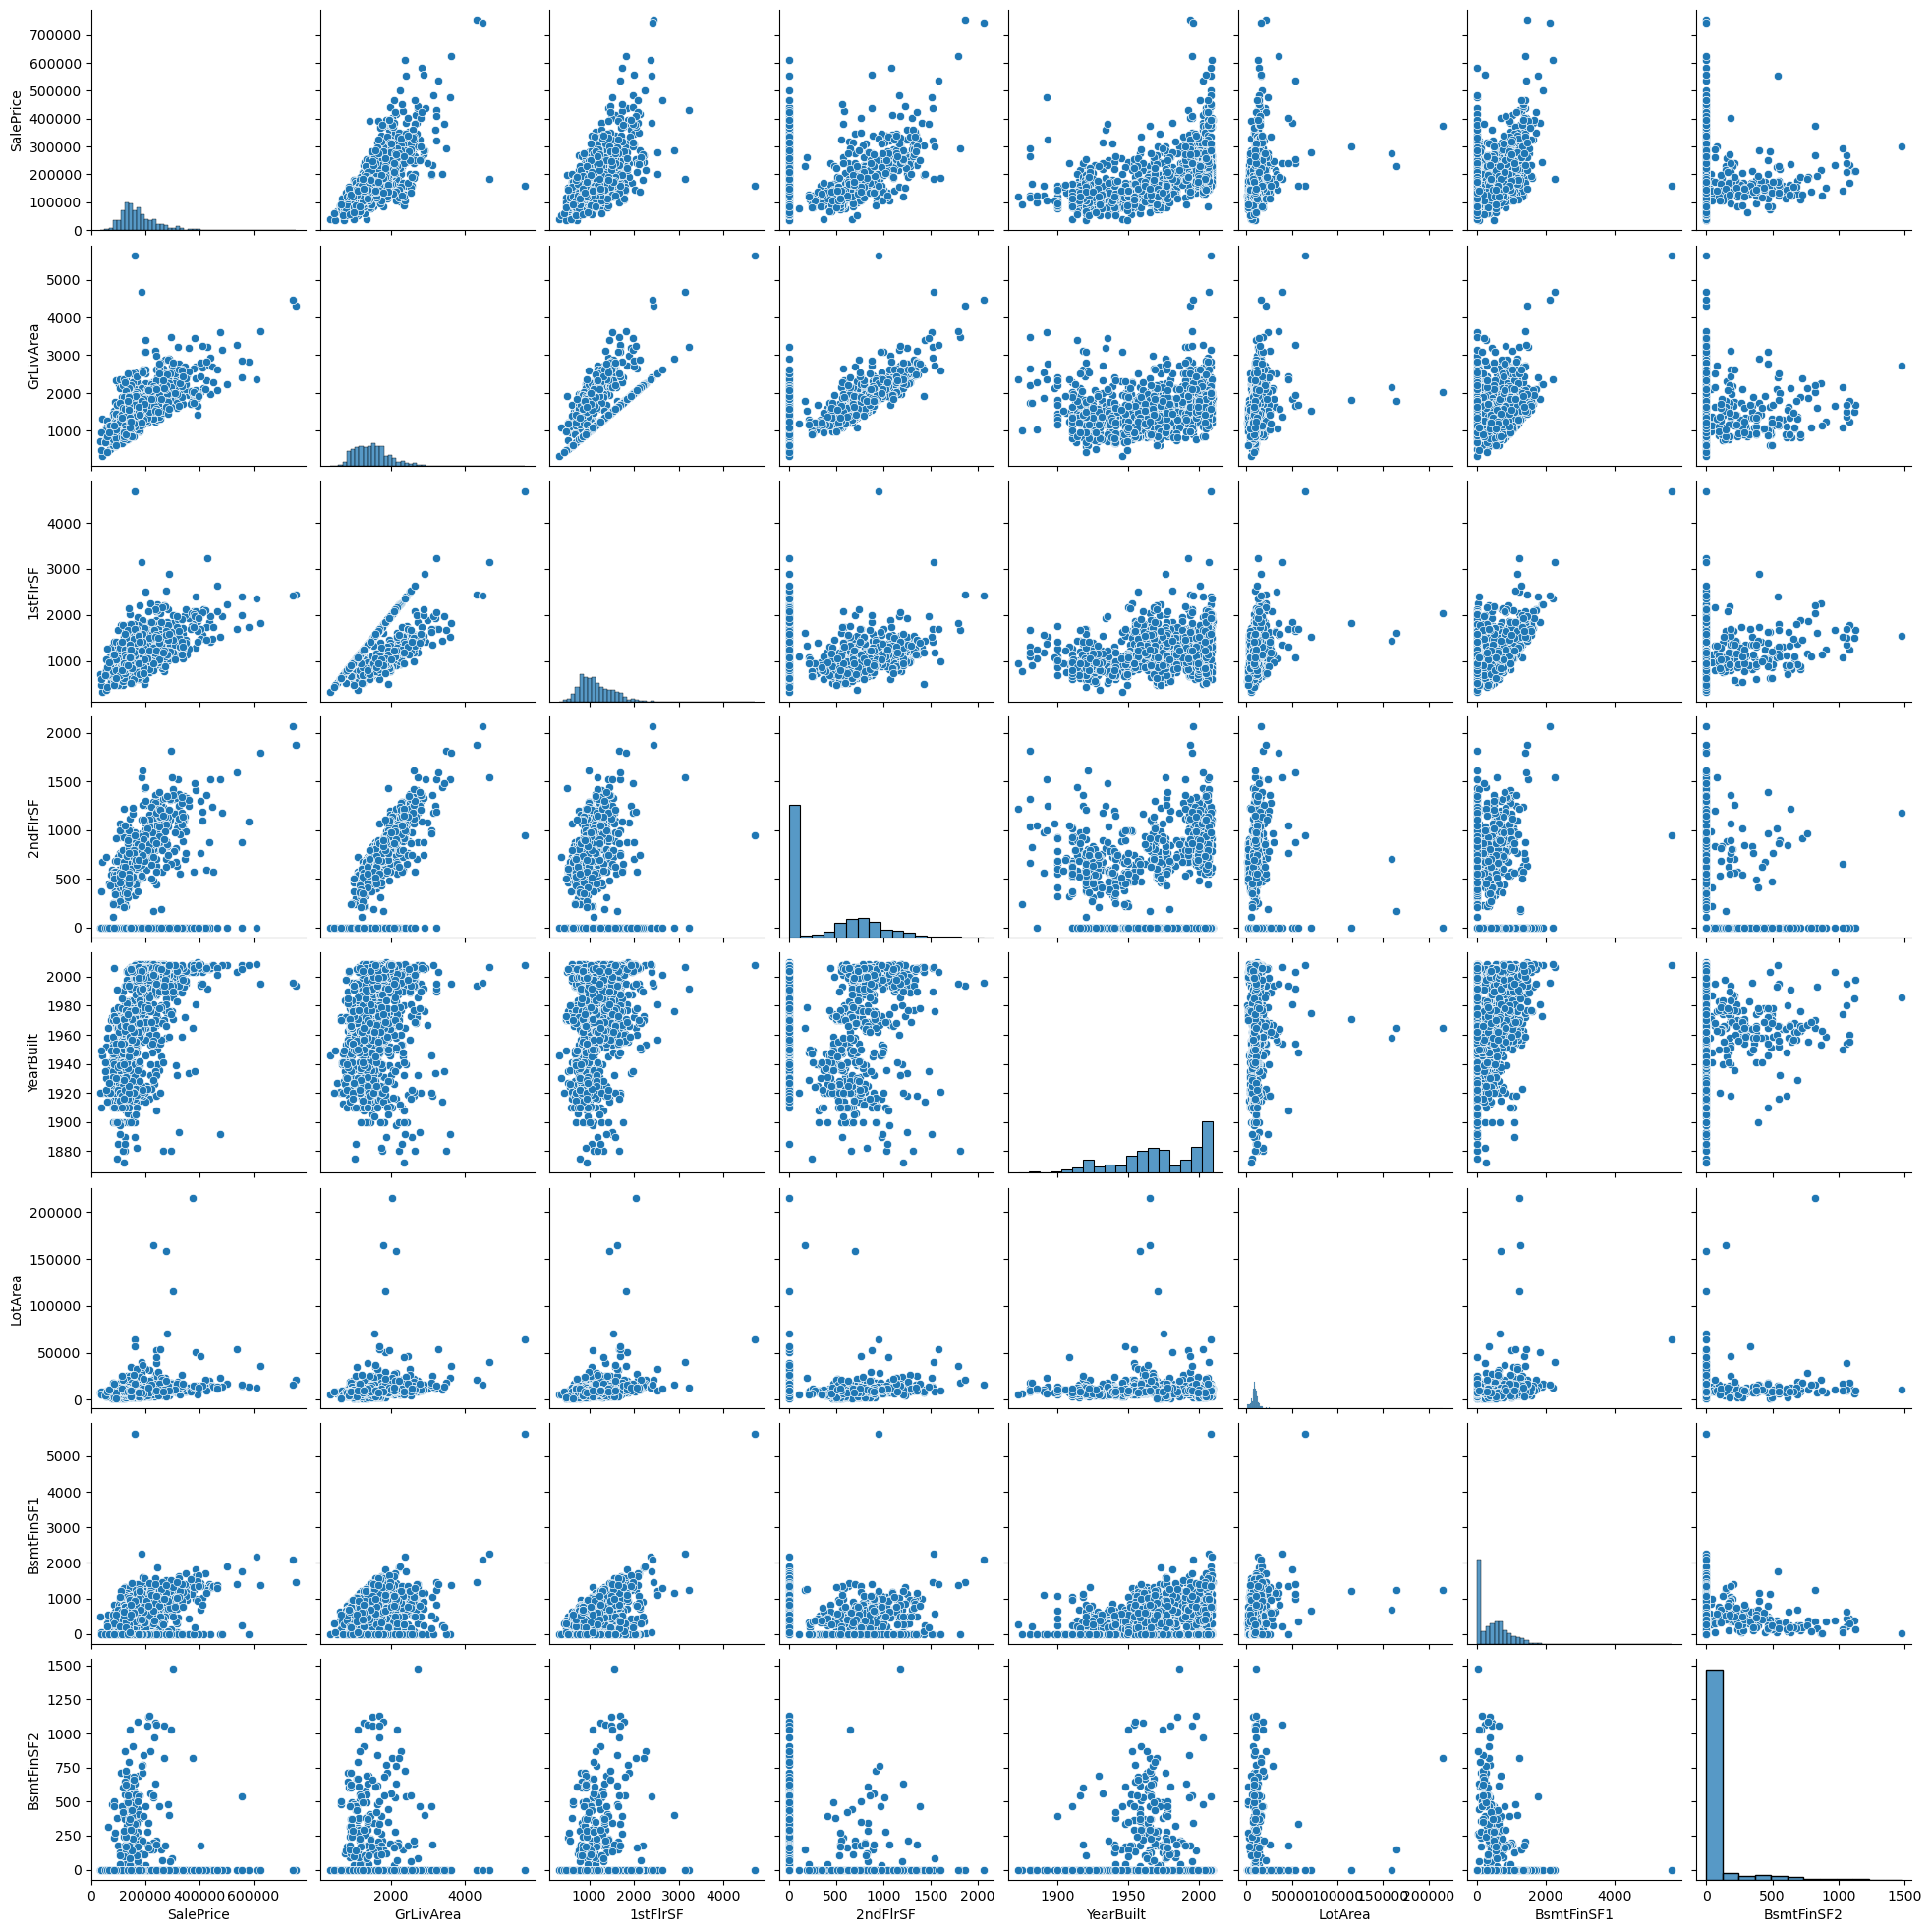

In [109]:
#Visualising Numeric Variables
sns.pairplot(home_df[['SalePrice','GrLivArea','1stFlrSF','2ndFlrSF','YearBuilt','LotArea','BsmtFinSF1','BsmtFinSF2']])
plt.show()

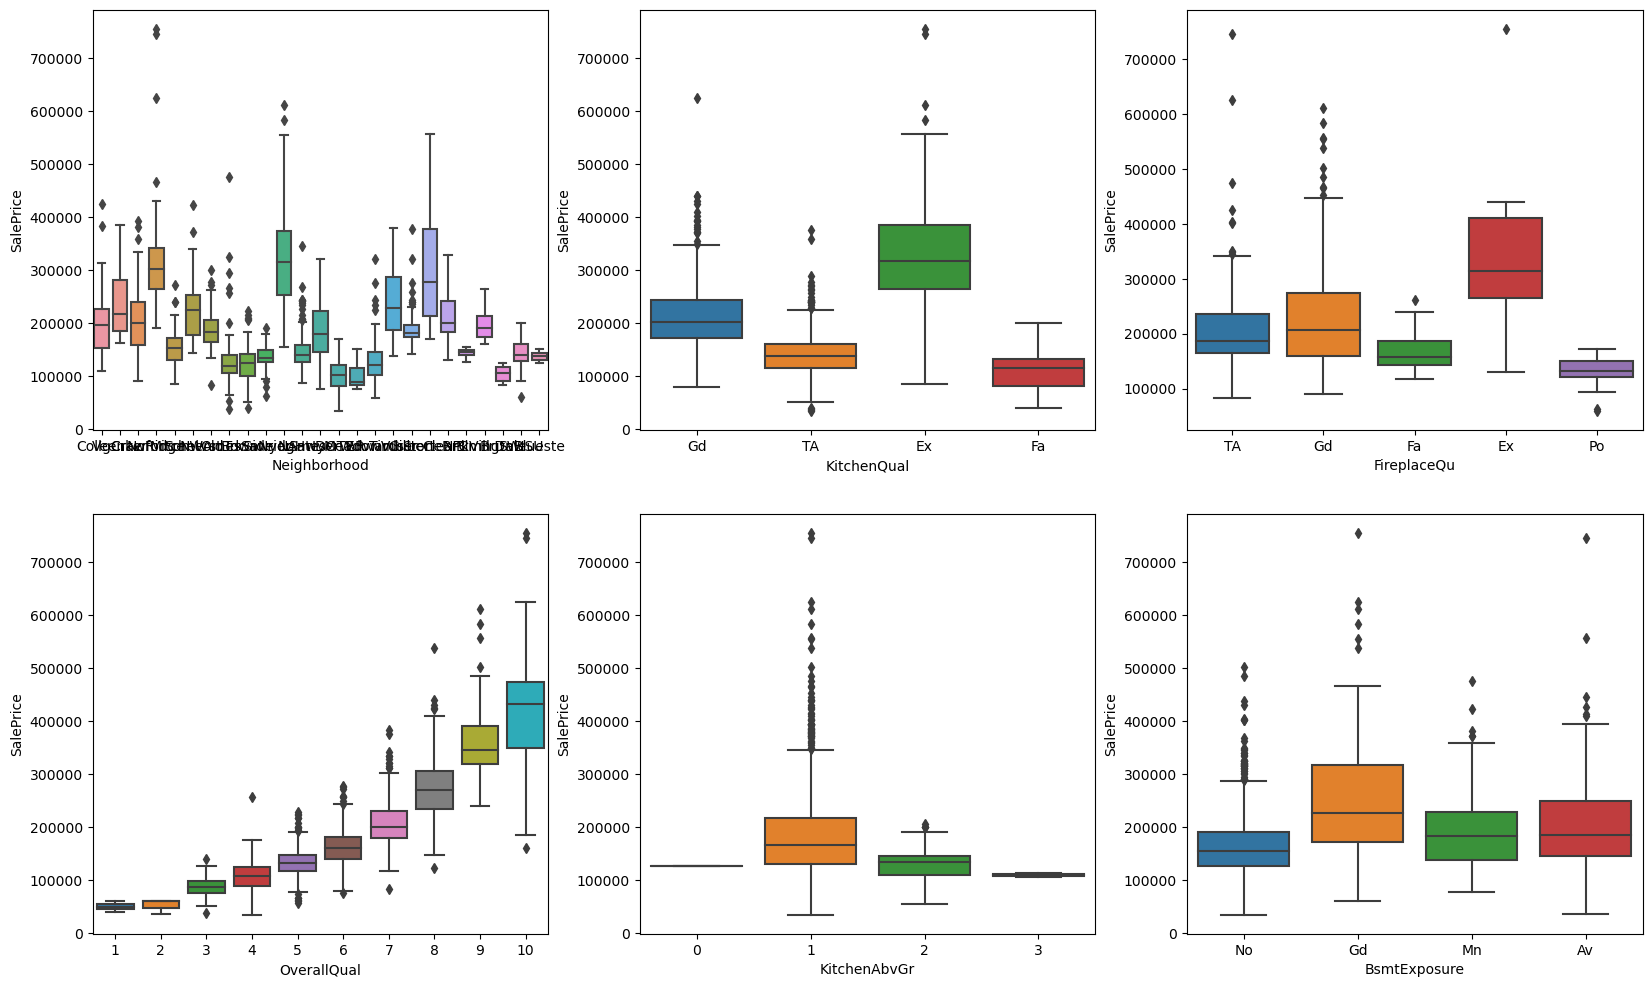

In [110]:
#Visualising Categorical Variables
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1) 
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = home_df)
plt.subplot(2,3,2)
sns.boxplot(x = 'KitchenQual', y = 'SalePrice', data = home_df)
plt.subplot(2,3,3)
sns.boxplot(x = 'FireplaceQu', y = 'SalePrice', data = home_df)
plt.subplot(2,3,4)
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = home_df)
plt.subplot(2,3,5)
sns.boxplot(x = 'KitchenAbvGr', y = 'SalePrice', data = home_df)
plt.subplot(2,3,6)
sns.boxplot(x = 'BsmtExposure', y = 'SalePrice', data = home_df)
plt.show()

### Data Cleaning

In [141]:
#MSSubClass, OverallQual, OverallCond are actually is a categorical variable
home_df['MSSubClass'] = home_df['MSSubClass'].astype('str')
home_df['OverallQual'] = home_df['OverallQual'].astype('str')
home_df['OverallCond'] = home_df['OverallCond'].astype('str')

In [142]:
#Finding Columns Having Null Values 
home_df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head(10)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageCond       5.55
GarageType       5.55
GarageFinish     5.55
dtype: float64

In [143]:
#finding & droping columns having missing values > 60%
home_df_most_null = list(home_df.columns[(home_df.isnull().sum()/len(home_df.index) * 100) > 60])
home_df_most_null.remove("Alley") #we can replace null with NA
home_df_most_null

['PoolQC', 'Fence', 'MiscFeature']

In [144]:
#Replecing the wrong values of features with the correct values from dictionary
home_df['MSZoning'] = home_df['MSZoning'].replace({'C (all)':'C'})
home_df['Neighborhood'] = home_df['Neighborhood'].replace({'NAmes':'Names'})
home_df['BldgType'] = home_df['BldgType'].replace({'2fmCon':'2FmCon', 'Duplex':'Duplx', 'Twnhs':'TwnhsE'}) 
home_df['Exterior2nd'] = home_df['Exterior2nd'].replace({'CmentBd':'CemntBd', 'Wd Shng':'Wd Sdng', 'Brk Cmn':'BrkComm'}) 
#null values for Alley featured filled with NA
home_df['Alley'].fillna('NA', inplace=True)
#MasVnrType, MasVnrArea with null values are to be filled with 'None' and '0.0' respectively
home_df['MasVnrType'].fillna('None', inplace=True)
home_df['MasVnrArea'].fillna(0.0, inplace=True)
#LotFrontage null values to be filled with 0.0
home_df['LotFrontage'].fillna(0.0, inplace=True)
#since Fireplaces 0, FireplaceQu feature will have value 'NA' 'No Fireplace'
home_df.loc[((home_df['Fireplaces'] == 0) & (home_df['FireplaceQu'].isnull())), 'FireplaceQu'] = 'NA'
#IF garage area 0 then garage built year = 0
home_df.loc[((home_df['GarageArea'] == 0) & (home_df['GarageYrBlt'].isnull())), 'GarageYrBlt'] = 0
#BsmtFinType2 filling mode value if BsmtFinSF2 is perially completed
modeValue = home_df.loc[((home_df['BsmtFinSF2'] > 0)),['BsmtFinType2']].BsmtFinType2.mode()
home_df.loc[((home_df['TotalBsmtSF'] > 0) & (home_df['BsmtFinSF2'] > 0) & (home_df['BsmtFinType2'].isnull()))
                       , ['BsmtFinType2']] = modeValue[0]
#Electrical filling single null value to mode value of the column
elect = home_df.Electrical.mode()
home_df.loc[home_df.Electrical.isnull(), ['Electrical']] = elect[0]

In [145]:
#Change data type 
if home_df.GarageYrBlt.dtype != int:
    home_df.GarageYrBlt = home_df.GarageYrBlt.astype(int)
#There are 4 year columns which are not dirctly usefull, instaed we will use them to calculate the age after these years
def calculateAge(madeYear):
    today = date.today()
    age = today.year - madeYear
    return age
#YearBuilt    YrSold   GarageYrBlt  YearRemodAdd
home_df['BuiltAge'] = home_df.YearBuilt.apply(lambda x: calculateAge(x) if x > 0 else 0)
home_df['SoldAge'] = home_df.YrSold.apply(lambda x: calculateAge(x) if x > 0 else 0)
home_df['GarageBltAge'] = home_df.GarageYrBlt.apply(lambda x: calculateAge(x) if x > 0 else 0)
home_df['RemodAddAge'] = home_df.YearRemodAdd.apply(lambda x: calculateAge(x) if x > 0 else 0)

In [146]:
#cleaning features values depending on other features
basementfeatures = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
garagefeatures = ['GarageType','GarageFinish','GarageQual','GarageCond']
FillAllNulls = basementfeatures
FillAllNulls.extend(garagefeatures)
FillAllNulls = set(FillAllNulls) #will remove duplicate column name values if any
FillAllNulls = list(FillAllNulls)
#[home_df[col].fillna('NA', inplace=True) for col in ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2']] 
for col in FillAllNulls:
    if col in basementfeatures:
        #since total basement square feet 0, all the listed features will have value 'No Basement' 'NA'
        home_df.loc[((home_df['TotalBsmtSF'] == 0) & (home_df[col].isnull())), col] = 'NA'
        #When all square feets for basement are unfinshed then maximum times BsmtExposure has value 'No'
        home_df.loc[((home_df['BsmtUnfSF'] == home_df['TotalBsmtSF']) & (home_df['TotalBsmtSF'] > 0) & 
                     (home_df[col].isnull())), col] = 'No'
    if col in garagefeatures:
        #since GarageArea 0, all above features will have value 'NA' 'No Garage'
        home_df.loc[((home_df['GarageArea'] == 0) & (home_df[col].isnull())), col] = 'NA'

In [147]:
#as Id is a unique value and has no significantly related to othe variables 
home_df_most_null.extend(['Id','YearBuilt','YrSold','GarageYrBlt','YearRemodAdd'])
home_df_most_null

['PoolQC',
 'Fence',
 'MiscFeature',
 'Id',
 'YearBuilt',
 'YrSold',
 'GarageYrBlt',
 'YearRemodAdd']

In [148]:
#First creating filter so it will check column exist or not, while droping column not exists error will not come
dropFilter = home_df.filter(home_df_most_null)
home_df.drop(dropFilter, axis=1, inplace=True)
home_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,BuiltAge,SoldAge,GarageBltAge,RemodAddAge
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,2,WD,Normal,208500,20,15,20,20
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,5,WD,Normal,181500,47,16,47,47
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,9,WD,Normal,223500,22,15,22,21
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,2,WD,Abnorml,140000,108,17,25,53
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,12,WD,Normal,250000,23,15,23,23


In [149]:
#Finding Columns Having Null Values 
home_df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head(10)

MSSubClass      0.0
KitchenAbvGr    0.0
GarageFinish    0.0
GarageType      0.0
FireplaceQu     0.0
Fireplaces      0.0
Functional      0.0
TotRmsAbvGrd    0.0
KitchenQual     0.0
BedroomAbvGr    0.0
dtype: float64

In [150]:
#checking any duplicate rows present
home_df.duplicated().any()

False

In [151]:
# head
home_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  RoofStyl

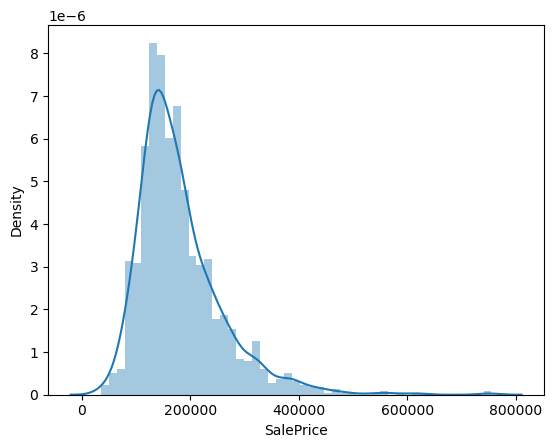

In [152]:
# target variable: price of house
sns.distplot(home_df['SalePrice'])
plt.show()

### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. 

In [153]:
#We'll first subset the list of all (independent) numeric variables
numerical_fetures = home_df.select_dtypes(include=['float64', 'int64'])
numerical_fetures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   MasVnrArea     1460 non-null   float64
 3   BsmtFinSF1     1460 non-null   int64  
 4   BsmtFinSF2     1460 non-null   int64  
 5   BsmtUnfSF      1460 non-null   int64  
 6   TotalBsmtSF    1460 non-null   int64  
 7   1stFlrSF       1460 non-null   int64  
 8   2ndFlrSF       1460 non-null   int64  
 9   LowQualFinSF   1460 non-null   int64  
 10  GrLivArea      1460 non-null   int64  
 11  BsmtFullBath   1460 non-null   int64  
 12  BsmtHalfBath   1460 non-null   int64  
 13  FullBath       1460 non-null   int64  
 14  HalfBath       1460 non-null   int64  
 15  BedroomAbvGr   1460 non-null   int64  
 16  KitchenAbvGr   1460 non-null   int64  
 17  TotRmsAbvGrd   1460 non-null   int64  
 18  Fireplac

In [154]:
numerical_fetures.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,BuiltAge,SoldAge,GarageBltAge,RemodAddAge
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,2,208500,20,15,20,20
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,5,181500,47,16,47,47
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,9,223500,22,15,22,21
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,0,0,0,2,140000,108,17,25,53
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,12,250000,23,15,23,23


In [155]:
# correlation matrix
cor = numerical_fetures.corr()
#cor.SalePrice.sort_values(ascending = False)
cor

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,BuiltAge,SoldAge,GarageBltAge,RemodAddAge
LotFrontage,1.000000,0.100739,0.105010,0.076670,-0.009312,0.160829,0.238274,0.245181,0.042549,0.049981,...,0.023499,0.022969,0.114106,-0.059606,0.018942,0.209624,-0.036853,0.012094,-0.033161,-0.078686
LotArea,0.100739,1.000000,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,...,0.020423,0.043160,0.077672,0.038068,0.001205,0.263843,-0.014228,0.014261,0.051767,-0.013788
MasVnrArea,0.105010,0.103321,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,...,0.019144,0.062248,0.011928,-0.029512,-0.006723,0.472614,-0.311600,0.008317,-0.179754,-0.176529
BsmtFinSF1,0.076670,0.214103,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,...,0.026451,0.062021,0.140491,0.003571,-0.015727,0.386420,-0.249503,-0.014359,-0.096151,-0.128451
BsmtFinSF2,-0.009312,0.111170,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,...,-0.029993,0.088871,0.041709,0.004940,-0.015211,-0.011378,0.049107,-0.031706,0.095726,0.067759
BsmtUnfSF,0.160829,-0.002618,0.113862,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,...,0.020764,-0.012579,-0.035092,-0.023837,0.034888,0.214479,-0.149040,0.041258,-0.158427,-0.181133
TotalBsmtSF,0.238274,0.260833,0.360067,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,...,0.037384,0.084489,0.126053,-0.018479,0.013196,0.613581,-0.391452,0.014969,-0.224331,-0.291066
1stFlrSF,0.245181,0.299475,0.339850,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,...,0.056104,0.088758,0.131525,-0.021096,0.031372,0.605852,-0.281986,0.013604,-0.148539,-0.240379
2ndFlrSF,0.042549,0.050986,0.173800,-0.137079,-0.099260,0.004469,-0.174512,-0.202646,1.000000,0.063353,...,-0.024358,0.040606,0.081487,0.016197,0.035164,0.319334,-0.010308,0.028700,-0.040029,-0.140024
LowQualFinSF,0.049981,0.004779,-0.068628,-0.064503,0.014807,0.028167,-0.033245,-0.014241,0.063353,1.000000,...,-0.004296,0.026799,0.062157,-0.003793,-0.022174,-0.025606,0.183784,0.028921,-0.029876,0.062419


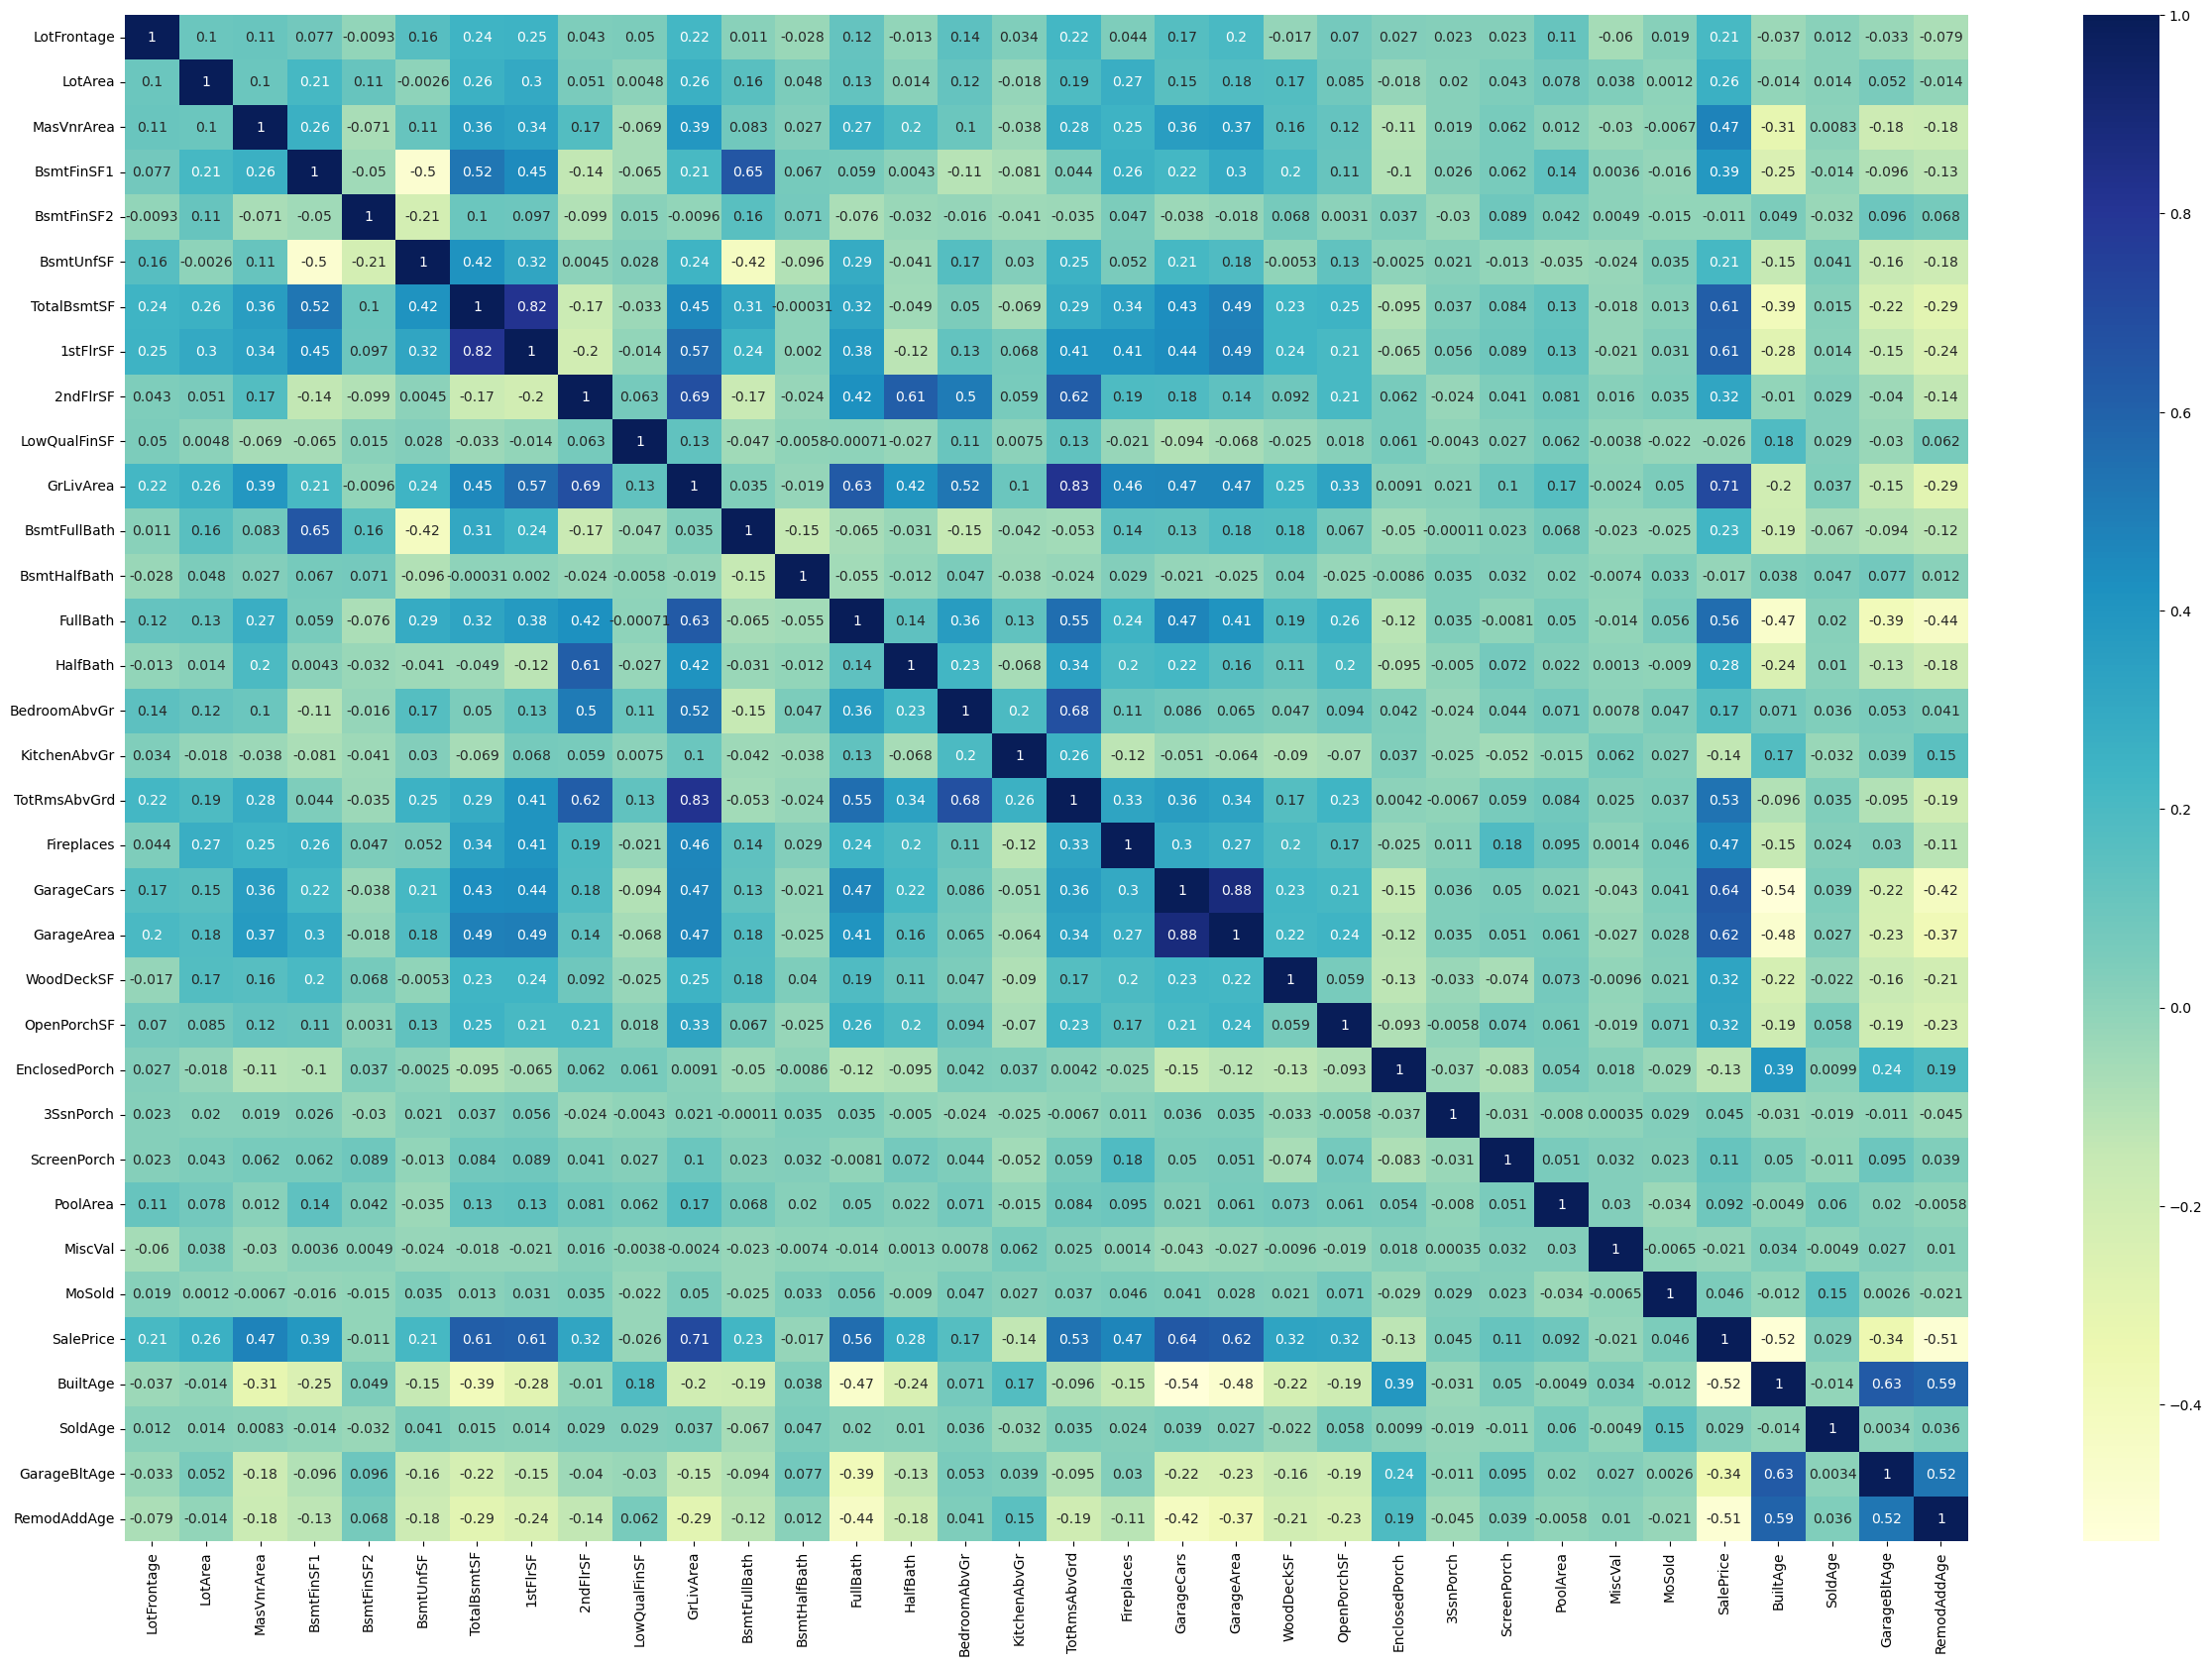

In [156]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

The heatmap shows some useful insights:

##### Correlation of price with independent variables:

House Sale Price is highly (positively) correlated with 'GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF', 'FullBath', 'TotRmsAbvGrd','MasVnrArea','Fireplaces','BsmtFinSF1','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath', 'LotArea','BsmtFullBath','BsmtUnfSF','LotFrontage','BedroomAbvGr','ScreenPorch','PoolArea','MoSold','3SsnPorch','SoldAge'.

Houce Sale Price is negatively correlated to 'BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','EnclosedPorch', 'KitchenAbvGr', 'GarageBltAge','RemodAddAge','BuiltAge'. This suggest that houses having kitchen above grade are mostly disliked by the customers, and are priced lower.

##### Correlation among independent variables:

Many independent variables are highly correlated. TotalBsmtSF, 1stFlrSF, TotalRmsAbvGr, GrLivArea etc are positively correlated.

### Data Preparation

Let's now prepare the data.

In [157]:
# subset all categorical variables
categorical_features = home_df.select_dtypes(include=['object'])
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   object
 15  OverallCond    1460 non-null   object
 16  RoofStyle      1460 non-null   object
 17  RoofMatl       1460 non-null   object
 18  Exterior1st    1460 non-null

In [158]:
# creating dummy variables for categorical variables
# convert into dummies - one hot encoding
home_df_dummies = pd.get_dummies(categorical_features, drop_first=True)
home_df_dummies.head()

,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [159]:
# drop categorical variables for which we have created dummy variables
dropFilter = home_df.filter(list(categorical_features.columns))
home_df.drop(dropFilter, axis=1, inplace=True)

In [160]:
# concat dummy variables with X
home_df = pd.concat([home_df, home_df_dummies], axis=1)

In [161]:
home_df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,0,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,...,0,0,0,0,1,0,0,0,1,0


In [162]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = home_df.columns
home_df = pd.DataFrame(scale(home_df))
home_df.columns = cols
home_df.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=279)

In [163]:
# split into X and y
y = home_df.pop('SalePrice') # response variable in Y
X = home_df # predictors in variable X

In [164]:
X.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.212877,-0.207142,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,0.645747,-0.091886,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,0.299451,0.073480,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,0.068587,-0.096897,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,0.937276,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,0.761179,0.375148,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,1.617877,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [165]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 2. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [166]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [167]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-1048606741.8958827
[ 1.04620437e-02  8.86994643e-02  3.43968836e-02 -2.59794661e+10
 -9.18878781e+09 -2.51688569e+10  2.49887696e+10 -6.84322128e+10
 -7.72725151e+10 -8.60706311e+09  9.30184326e+10  1.04961395e-02
 -8.07285309e-04  1.04610920e-02 -2.02693939e-02 -1.89151764e-02
 -4.68902588e-02 -2.16088295e-02  1.77936554e-02  3.34835052e-02
  3.46527100e-02  8.25309753e-03  2.27413177e-02  7.31158257e-03
  1.53846741e-02  1.67388916e-02  4.72936630e-02  7.31086731e-03
 -1.05695724e-02 -1.74609184e-01  4.81557846e-03 -8.02421570e-03
 -2.20069885e-02 -1.71500444e-03 -2.63118744e-03 -5.98150545e+10
 -1.64690018e-02  2.86865234e-03  2.20298767e-03 -1.07574463e-02
 -1.63364410e-02  8.14247131e-03  3.61061096e-03 -3.93823385e-02
 -1.75857544e-02 -1.88217163e-02  2.71768848e+10  9.77063179e-02
  5.24368286e-02  2.02945709e-01  1.59028053e-01  1.98693275e-02
  6.86216354e-03  3.82304192e-03  5.01823425e-03  7.39383698e-03
  2.58255005e-03 -6.97898865e-03 -1.50604248e-02  1.03483200e-02
 -4.4

In [168]:
from sklearn.metrics import r2_score, mean_squared_error

In [169]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9569162986296403
-2.702252107141158e+21
43.58860581588001
1.2077258927401444e+24
0.04269207229762978
2.7573650519181377e+21


##### With above r2 values we clearly understand that model is performing significantly on the training set but on training set it failed to perform. This problem is due to overfitting. Lets see Ridge and Lasso regression helps us to come out of the overfitting problem.

## Ridge and Lasso Regression

Let's now try predicting House prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [170]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [171]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [172]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 2.12785644e-03  3.50175071e-02  4.13888030e-02  2.71021561e-02
  1.12746758e-02  1.02643755e-02  4.26608739e-02  6.51129690e-02
  6.02866889e-02 -5.96349273e-03  9.74323070e-02  2.95733985e-02
  2.58920889e-03  5.23461506e-02  2.53207489e-02  9.10704516e-03
 -2.30051793e-02  4.96047252e-02  3.44791126e-02  5.57641239e-02
  3.85111092e-02  1.95720954e-02  1.23656235e-02  1.97770350e-03
  1.42557085e-02  1.58841318e-02 -3.13438575e-03  1.57430492e-03
 -3.21304940e-03 -2.41677999e-02  5.63154856e-03 -1.07425004e-02
 -3.77849940e-02 -1.72803793e-02 -7.32398823e-03 -1.17497588e-02
  1.89001852e-02 -8.87536876e-03  2.29425328e-03  1.71154671e-03
  6.07767795e-03  9.37420479e-03  1.05456491e-02  4.35097083e-03
 -8.57134133e-03 -2.58976240e-03 -9.42236798e-03  9.26431988e-03
  3.36101455e-03  1.46926327e-02 -9.43730213e-03  8.70206325e-03
  4.20615101e-03  6.70380694e-03  6.05860316e-03 -2.57639657e-02
 -5.75197655e-03  1.27765761e-02  6.46745979e-03  1.98705652e-02
 -1.13233052e-02  2.47611

In [173]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8936084915279175
0.8624484872054756
107.638326732459
61.47632308196268
0.10542441403766797
0.14035690201361342


## Lasso

In [174]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [175]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.01}


In [176]:
#Fitting Ridge model for alpha = 0.01 and printing coefficients which have been penalised

alpha =0.01

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [177]:
lasso.coef_

array([-0.00000000e+00,  4.51034845e-02,  1.25321727e-02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.41450758e-02,  0.00000000e+00,
        0.00000000e+00, -1.79213746e-02,  3.62796341e-01,  4.05288078e-02,
        3.33448184e-04,  3.34217761e-02,  0.00000000e+00, -0.00000000e+00,
       -5.44837946e-02,  0.00000000e+00,  0.00000000e+00,  8.92458942e-02,
        0.00000000e+00,  3.16906568e-03,  0.00000000e+00,  0.00000000e+00,
        8.60573631e-03,  1.59911480e-02, -1.65614121e-02,  0.00000000e+00,
       -0.00000000e+00, -7.72944762e-02,  0.00000000e+00, -0.00000000e+00,
       -5.04130434e-02, -1.83534940e-02, -0.00000000e+00, -6.72364520e-03,
        4.65861958e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.02471036e-02, -0.00000000e+00,  6.30170749e-03,
        0.00000000e+00,  

In [178]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9066942909483535
0.8439611774567116
94.39917283944024
69.73891361216718
0.09245756399553402
0.15922126395471958


In [179]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.569163e-01,0.893608,0.906694
1,R2 Score (Test),-2.702252e+21,0.862448,0.843961
2,RSS (Train),4.358861e+01,107.638327,94.399173
3,RSS (Test),1.207726e+24,61.476323,69.738914
4,MSE (Train),2.066206e-01,0.324691,0.304068
5,MSE (Test),5.251062e+10,0.374642,0.399025


## Lets observe the changes in the coefficients after regularization

In [180]:
betas = pd.DataFrame(index=X.columns)

In [181]:
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Linear,Ridge,Lasso
LotFrontage,1.046204e-02,0.002128,-0.000000
LotArea,8.869946e-02,0.035018,0.045103
MasVnrArea,3.439688e-02,0.041389,0.012532
BsmtFinSF1,-2.597947e+10,0.027102,0.000000
BsmtFinSF2,-9.188788e+09,0.011275,0.000000
BsmtUnfSF,-2.516886e+10,0.010264,-0.000000
TotalBsmtSF,2.498877e+10,0.042661,0.014145
1stFlrSF,-6.843221e+10,0.065113,0.000000
2ndFlrSF,-7.727252e+10,0.060287,0.000000
LowQualFinSF,-8.607063e+09,-0.005963,-0.017921


## Subject Questions Answers

##### Question 1

##### Ridge

In [182]:
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised
alpha1 = 1000
ridge1 = Ridge(alpha=alpha1)

ridge1.fit(X_train, y_train)
print(ridge1.coef_)

[ 7.74543260e-03  2.91612243e-02  4.06470169e-02  2.97550676e-02
  8.47302962e-03  1.08433417e-02  4.49718884e-02  5.90288179e-02
  4.54661574e-02 -3.97624731e-03  8.08284223e-02  2.52056402e-02
  1.80321347e-03  4.48504162e-02  2.38925510e-02  1.15353685e-02
 -1.74227771e-02  4.81257048e-02  3.58881746e-02  4.82179034e-02
  4.11611059e-02  2.20383541e-02  1.37895939e-02  1.18934705e-03
  1.13343072e-02  1.30983452e-02  9.99695097e-04  9.14023761e-04
 -2.16628084e-03 -2.04220719e-02  4.08560963e-03 -1.30944688e-02
 -3.42333034e-02 -1.54944393e-02 -6.81575120e-03 -9.55184158e-03
  1.20242325e-02 -1.11003880e-02  1.89833791e-03  1.11062171e-03
  3.55570495e-03  1.44166106e-02  9.96686373e-03  2.80987169e-03
 -7.98159582e-03 -3.20761798e-03 -8.88100861e-03  7.80170913e-03
  1.98321247e-03  1.32817874e-02 -1.26572210e-02  6.82737740e-03
  4.54623481e-03  3.60022163e-03  6.36680398e-03 -1.96287516e-02
 -9.68232221e-03  1.06625292e-02  6.09169880e-03  1.11675876e-02
 -8.94973145e-03  2.06247

In [183]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge1.predict(X_train)
y_pred_test = ridge1.predict(X_test)

metric21 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric21.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric21.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric21.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric21.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric21.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric21.append(mse_test_lr**0.5)

0.8701061088244612
0.8513910969037953
131.41613743141858
66.4182367317595
0.12871316104938157
0.1516398098898619


##### Lasso

In [184]:
#Fitting Ridge model for alpha = 0.02 and printing coefficients which have been penalised
alpha1 = 0.02
lasso1 = Lasso(alpha=alpha1)
lasso1.fit(X_train, y_train) 

Lasso(alpha=0.02)

In [185]:
lasso1.coef_

array([-0.00000000e+00,  3.35784959e-02,  1.21613897e-02,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  3.40223899e-02,  0.00000000e+00,
        0.00000000e+00, -1.30903084e-02,  3.47597105e-01,  3.52254495e-02,
        0.00000000e+00,  2.43769624e-02,  0.00000000e+00, -0.00000000e+00,
       -5.73255419e-02,  0.00000000e+00,  1.33370477e-02,  9.96876786e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.48717055e-03,  6.28920949e-03, -7.29252540e-03,  0.00000000e+00,
       -0.00000000e+00, -6.37101828e-02,  0.00000000e+00, -0.00000000e+00,
       -6.39039829e-02, -9.79419515e-03, -0.00000000e+00, -0.00000000e+00,
        3.39219585e-02, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.18035378e-03, -9.11640065e-03,  0.00000000e+00,
        0.00000000e+00,  

In [186]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso1.predict(X_train)
y_pred_test = lasso1.predict(X_test)

metric31 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric31.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric31.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric31.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric31.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric31.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric31.append(mse_test_lr**0.5)

0.8855049367604679
0.8401985821316182
115.83684829005111
71.4205419791169
0.11345430782571117
0.16306059812583767


In [187]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric1 = pd.Series(metric21, name = 'Ridge Regression')
ls_metric1 = pd.Series(metric31, name = 'Lasso Regression')

final_metric1 = pd.concat([lr_metric, rg_metric1, ls_metric1], axis = 1)

final_metric1

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.569163e-01,0.870106,0.885505
1,R2 Score (Test),-2.702252e+21,0.851391,0.840199
2,RSS (Train),4.358861e+01,131.416137,115.836848
3,RSS (Test),1.207726e+24,66.418237,71.420542
4,MSE (Train),2.066206e-01,0.358766,0.336830
5,MSE (Test),5.251062e+10,0.389410,0.403808


In [188]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge1.coef_
betas['Lasso'] = lasso1.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Linear,Ridge,Lasso
LotFrontage,1.046204e-02,0.007745,-0.000000e+00
LotArea,8.869946e-02,0.029161,3.357850e-02
MasVnrArea,3.439688e-02,0.040647,1.216139e-02
BsmtFinSF1,-2.597947e+10,0.029755,0.000000e+00
BsmtFinSF2,-9.188788e+09,0.008473,0.000000e+00
BsmtUnfSF,-2.516886e+10,0.010843,-0.000000e+00
TotalBsmtSF,2.498877e+10,0.044972,3.402239e-02
1stFlrSF,-6.843221e+10,0.059029,0.000000e+00
2ndFlrSF,-7.727252e+10,0.045466,0.000000e+00
LowQualFinSF,-8.607063e+09,-0.003976,-1.309031e-02


### Question 3

In [189]:
#'GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'
dropFilter = X_train.filter(['GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'])
X_train.drop(dropFilter, axis=1, inplace=True)
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.270593,-0.492374,-0.570750,0.053428,-0.288653,-0.387671,-0.441061,-0.772733,-0.795163,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
318,0.934327,-0.061820,0.846202,1.191731,-0.288653,-0.469172,0.660283,0.541779,2.124318,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
239,-0.162277,-0.177977,-0.570750,-0.766852,-0.288653,0.166984,-0.735209,-0.943516,0.783740,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
986,0.039729,-0.521839,-0.570750,-0.973018,-0.288653,-0.186184,-1.305262,-0.418229,0.657703,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1416,0.068587,0.082500,-0.570750,-0.973018,-0.288653,0.474875,-0.639440,0.215738,1.597253,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [190]:
#'GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'
dropFilter = X_test.filter(['GrLivArea','OverallQual_10','OverallQual_9','OverallQual_8','GarageCars'])
X_test.drop(dropFilter, axis=1, inplace=True)
X_test.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.068587,-0.152020,-0.570750,0.378031,-0.288653,-0.722728,-0.441061,-0.772733,-0.795163,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
57,0.905469,0.113068,-0.570750,-0.973018,-0.288653,0.662778,-0.450182,-0.783083,1.175601,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
780,0.155161,-0.264769,-0.360421,-0.973018,-0.288653,1.516269,0.409460,0.233852,-0.795163,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
382,0.616889,-0.127465,-0.570750,-0.973018,-0.288653,0.841627,-0.270045,-0.578661,1.171018,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1170,0.530315,-0.063824,-0.570750,0.171865,-0.288653,0.015303,0.087949,-0.115477,-0.795163,-0.120242,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [196]:
X_train.shape

(1021, 273)

In [197]:
X_test.shape

(438, 273)

In [192]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha2 = 0.02
lasso2 = Lasso(alpha=alpha2)
lasso2.fit(X_train, y_train) 
lasso2.coef_

array([ 0.00000000e+00,  2.60358410e-02,  3.33462697e-02,  1.09192688e-03,
        0.00000000e+00, -0.00000000e+00,  8.32196571e-02,  2.41864182e-01,
        2.70532901e-01, -0.00000000e+00,  2.45191504e-02,  0.00000000e+00,
        3.85629366e-02,  4.93635179e-03, -0.00000000e+00, -7.39206548e-02,
        2.52021581e-02,  4.35224545e-02,  7.77471045e-02,  1.02389760e-02,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  4.47576923e-03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.70906034e-02,
        0.00000000e+00, -0.00000000e+00, -7.72225280e-02, -1.19339049e-02,
       -0.00000000e+00, -0.00000000e+00,  1.62022726e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -2.74192146e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

In [193]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso2.predict(X_train)
y_pred_test = lasso2.predict(X_test)

metric33 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric33.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric33.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric33.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric33.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric33.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric33.append(mse_test_lr**0.5)

0.8673753653077011
0.8275964230365664
134.17888294655233
77.05286392395078
0.13141908221993373
0.17591978064828945


In [194]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Lasso'] = lasso2.coef_
pd.set_option('display.max_rows', None)
betas.head(300)

,Lasso
LotFrontage,0.000000
LotArea,0.026036
MasVnrArea,0.033346
BsmtFinSF1,0.001092
BsmtFinSF2,0.000000
BsmtUnfSF,-0.000000
TotalBsmtSF,0.083220
1stFlrSF,0.241864
2ndFlrSF,0.270533
LowQualFinSF,-0.000000
